# Topic Labelling for Yahoo! Answers

This notebook presents a comprehensive project on topic labeling using the Yahoo! Answers dataset, which encompasses a diverse range of queries and responses categorized into ten distinct topics. Topic labeling, involves assigning predefined labels to textual data based on its content. In this project, we aim to explore and compare the effectiveness of traditional machine learning methods and state-of-the-art models in accurately labeling the topics of Yahoo! Answers entries.



To achieve this, we employ a mix of classic algorithms such as Naive Bayes, Support Vector Machines, alongside advanced techniques including deep learning models like RoBERTa and transformer architectures. By evaluating and contrasting the performance of these varied approaches, we seek to gain insights into their strengths and limitations in handling the Yahoo! Answers dataset. This comparison will help in identifying the most suitable techniques for effective topic labeling in large-scale, real-world text classification tasks.

# Importing Libraries

In [ ]:
!pip install wordcloud torchinfo

In [ ]:
# Standard library imports
import glob
import json
import os
import pathlib
import re
import string
from collections import Counter
from typing import List, Tuple

# Third-party library imports
import numpy as np
import pandas as pd
import torch
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset
from torchinfo import summary
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, f1_score,
                             precision_score, recall_score, precision_recall_fscore_support)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from google.colab import drive
from transformers import (RobertaTokenizer, RobertaForSequenceClassification, RobertaModel,
                          ElectraTokenizer, ElectraForSequenceClassification, ElectraModel,
                          XLNetTokenizer, XLNetForSequenceClassification, XLNetModel,
                          T5Tokenizer, T5ForConditionalGeneration, T5ForSequenceClassification,
                          T5EncoderModel, Trainer, TrainingArguments, TrainerCallback, pipeline)

# Data Loading

In [ ]:
import zipfile
import os
import pandas as pd

# Paths
zip_path = '/content/train.csv.zip'
extract_dir = '/content/train_csv_extracted'

# Unzip the file
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# List extracted files to identify the CSV file
extracted_files = os.listdir(extract_dir)
print("Extracted files:", extracted_files)

# Load the CSV file
csv_path = os.path.join(extract_dir, 'train.csv')

df = pd.read_csv(
    csv_path,
    delimiter=",",
    index_col=False,
    on_bad_lines='skip',
    names=["class", "question", "content", "answer"]
)

# Display the shape and the first few rows of the dataframe
print("Dataset has shape:", df.shape)
df = df.iloc[:100000]
print("Dataset has shape after slicing:", df.shape)
df.head()


Extracted files: ['train.csv']
Dataset has shape: (1400000, 4)
Dataset has shape after slicing: (1000, 4)


,class,question,content,answer
0,5,why doesn't an optical mouse work on a glass t...,or even on some surfaces?,Optical mice use an LED and a camera to rapidl...
1,6,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...
2,3,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...
3,7,How many planes Fedex has?,I heard that it is the largest airline in the ...,according to the www.fedex.com web site:\nAir ...
4,7,"In the san francisco bay area, does it make se...",the prices of rent and the price of buying doe...,renting vs buying depends on your goals. <br /...


In [ ]:
#import pandas as pd

# Replace 'yourfile.csv' with the name of your uploaded file
#df = pd.read_csv('/content/train.csv.zip')

# Display the first few rows of the dataframe
#df.head()


,5,why doesn't an optical mouse work on a glass table?,or even on some surfaces?,"Optical mice use an LED and a camera to rapidly capture images of the surface beneath the mouse. The infomation from the camera is analyzed by a DSP (Digital Signal Processor) and used to detect imperfections in the underlying surface and determine motion. Some materials, such as glass, mirrors or other very shiny, uniform surfaces interfere with the ability of the DSP to accurately analyze the surface beneath the mouse. \nSince glass is transparent and very uniform, the mouse is unable to pick up enough imperfections in the underlying surface to determine motion. Mirrored surfaces are also a problem, since they constantly reflect back the same image, causing the DSP not to recognize motion properly. When the system is unable to see surface changes associated with movement, the mouse will not work properly."
0,6,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...
1,3,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...
2,7,How many planes Fedex has?,I heard that it is the largest airline in the ...,according to the www.fedex.com web site:\nAir ...
3,7,"In the san francisco bay area, does it make se...",the prices of rent and the price of buying doe...,renting vs buying depends on your goals. <br /...
4,5,What's the best way to clean a keyboard?,I have very small stuff stuck under my keyboar...,"There are commercial kits available, but a can..."


In [ ]:
#df = pd.read_csv(url+"/train.csv", delimiter=",", index_col=False, on_bad_lines='skip', names=["class", "question", "content", "answer"])
#print("Dataset has shape:", df.shape)
#df = df.iloc[:1000]
#print("Dataset has shape:", df.shape)

It can be noticed that a portion of the dataset is empty. Such rows are identified and deleted

In [ ]:
df.isna().sum()

class         0
question      0
content     615
answer        0
dtype: int64

In [ ]:
df.dropna(inplace = True)
print("Dataset has shape:", df.shape)

Dataset has shape: (385, 4)


In [ ]:
df.head(5)

,class,question,content,answer
0,5,why doesn't an optical mouse work on a glass t...,or even on some surfaces?,Optical mice use an LED and a camera to rapidl...
1,6,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...
2,3,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...
3,7,How many planes Fedex has?,I heard that it is the largest airline in the ...,according to the www.fedex.com web site:\nAir ...
4,7,"In the san francisco bay area, does it make se...",the prices of rent and the price of buying doe...,renting vs buying depends on your goals. <br /...


In [ ]:
# Preparing our data, regrouping it into a singular column "text"
df["text"] = df["question"] + " " + df["content"] + " " + df["answer"]

# Adjust the class labels to be zero-indexed
df['class'] = df['class'] - 1

In [ ]:
def split_data(df, train_size=0.7, validation_size=0.15, test_size=0.15, random_state=123):
    # Split the dataset into training and the rest
    train_df, rest_df = train_test_split(df, train_size=train_size, random_state=random_state)

    # Calculate the proportion of validation and test size relative to the rest set
    rest_size = validation_size + test_size
    validation_prop = validation_size / rest_size
    test_prop = test_size / rest_size

    # Split the rest into validation and test sets
    val_df, test_df = train_test_split(rest_df, test_size=test_prop, random_state=random_state)

    return train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df.reset_index(drop=True)

train_df, val_df, test_df = split_data(df[["text", "class"]])


In [ ]:
print("Train dataset has shape: ", train_df.shape)
print("val dataset has shape: ", val_df.shape)
print("Test dataset has shape: ", test_df.shape)

Train dataset has shape:  (269, 2)
val dataset has shape:  (58, 2)
Test dataset has shape:  (58, 2)


In [ ]:
train_df.head()

,text,class
0,Could a very powerful directional microphone p...,1
1,What's the best way to clean a keyboard? I hav...,4
2,Who will win 2005 heisman trophy? Reggie? Vinc...,5
3,How did language start? Especially the English...,3
4,How a black hole is formed? I would like to kn...,1


# Understanding our Dataset through Preliminary Statistics

To begin, it is worthwhile looking at potential imbalance in class distribution within the dataset. It will inform the choice for metrics to be used when measuring model performances.

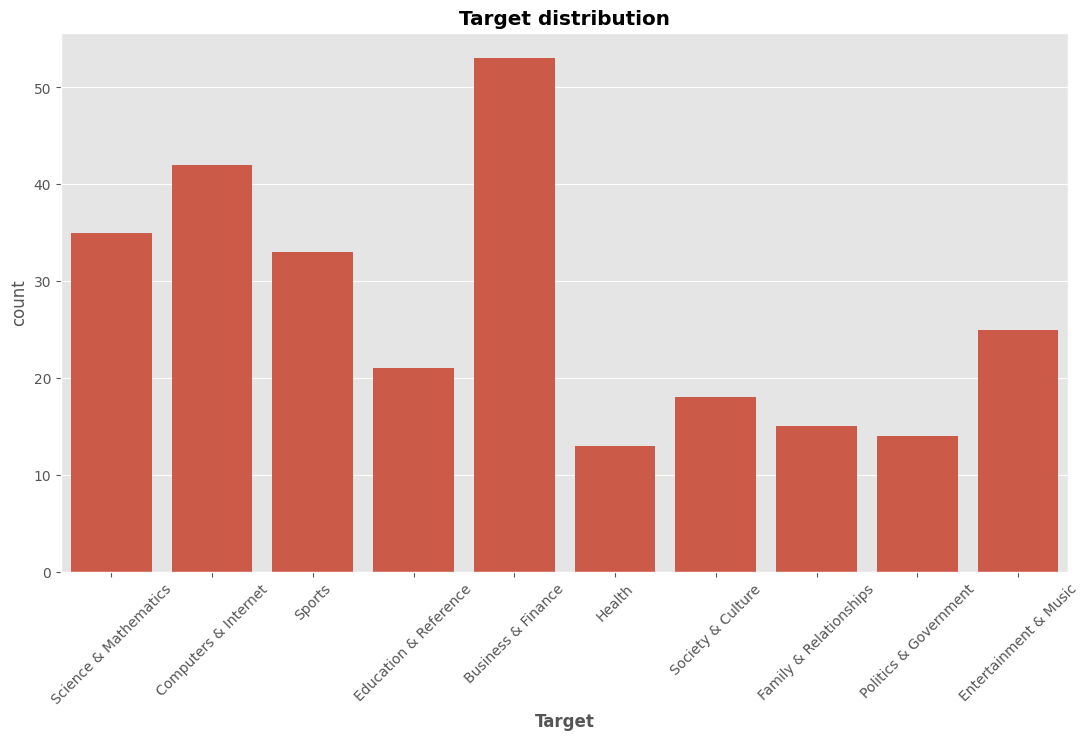

In [ ]:
categories = {0: 'Society & Culture', 1: 'Science & Mathematics', 2: 'Health', 3: 'Education & Reference',
              4: 'Computers & Internet', 5: 'Sports', 6: 'Business & Finance', 7: 'Entertainment & Music',
              8: 'Family & Relationships', 9: 'Politics & Government'}
train_df["category"] = train_df['class'].map(categories)

plt.figure(figsize=(13, 7))
plt.style.use('ggplot')
sns.countplot(x = 'category', data = train_df)
plt.title('Target distribution', fontweight='bold')
plt.xlabel('Target', fontweight='bold')
plt.xticks(rotation=45);

As can be seen, the class distribution is relatively balanced. This balance leads to more reliable and unbiased performance metrics, providing a clearer evaluation of the model's effectiveness across all categories.

Including a word cloud helps visualize the most frequent words in the dataset, providing an intuitive and immediate understanding of the prominent terms and themes within the text. This can aid in identifying common topics and trends, and uncovering potential insights for further analysis.

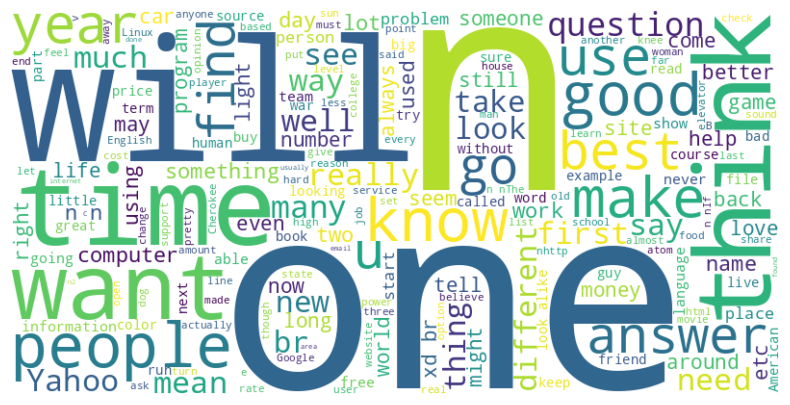

In [ ]:
def create_word_cloud(df, text_column, sample_size=100000, max_words=200):

    # Sample the dataset because it is too large
    if len(df) > sample_size:
        df = df.sample(n=sample_size, random_state=123)

    # Combine all text data into a single string
    text = ' '.join(df[text_column].astype(str).values)

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=max_words).generate(text)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()



# Create and display the word cloud
create_word_cloud(df, 'text')

# Data Preprocessing

In [ ]:
# Download the necessary NLTK data files
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Define the stop words and lemmatizer outside the function to avoid re-initializing them
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    try:
        # Remove HTML tags
        text = BeautifulSoup(text, "html.parser").get_text()
    except Exception as e:
        print(f"Error parsing HTML: {e}")
        text = re.sub(r'<[^>]+>', '', text)

    # Convert to lowercase
    text = text.lower()

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize
    words = word_tokenize(text)

    # Remove stop words
    words = [word for word in words if word not in stop_words]

    # Lemmatize
    words = [lemmatizer.lemmatize(word) for word in words]

    # Join words back to a single string
    text = ' '.join(words)

    return text


# Apply preprocessing
train_df['cleaned_text'] = train_df['text'].apply(preprocess_text)

val_df['cleaned_text'] = val_df['text'].apply(preprocess_text)

test_df['cleaned_text'] = test_df['text'].apply(preprocess_text)

# Display the cleaned text
train_df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
<ipython-input-17-24cb7c928582>:13: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
<ipython-input-17-24cb7c928582>:13: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
<ipython-input-17-24cb7c928582>:13: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "ht

,text,class,category,cleaned_text
0,Could a very powerful directional microphone p...,1,Science & Mathematics,could powerful directional microphone pickup s...
1,What's the best way to clean a keyboard? I hav...,4,Computers & Internet,'s best way clean keyboard ? small stuff stuck...
2,Who will win 2005 heisman trophy? Reggie? Vinc...,5,Sports,win 2005 heisman trophy ? reggie ? vince ? mat...
3,How did language start? Especially the English...,3,Education & Reference,language start ? especially english language ....
4,How a black hole is formed? I would like to kn...,1,Science & Mathematics,black hole formed ? would like know black hole...


# Traditional Machine Learning Models

In this section, data is first vectorized using TF-IDF vectorization before being passed in to ML models.

The following ML models are implemented and compared: Logistic Regression, Naive Bayes and SVM.

In [ ]:
# Split the data into training and testing sets
X_train = train_df['cleaned_text']
y_train = train_df['class']
X_test = test_df['cleaned_text']
y_test = test_df['class']


# Vectorize text using TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


# Initialize models
models = {
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC()
}

# Train models
for model in models.values():
    model.fit(X_train_tfidf, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


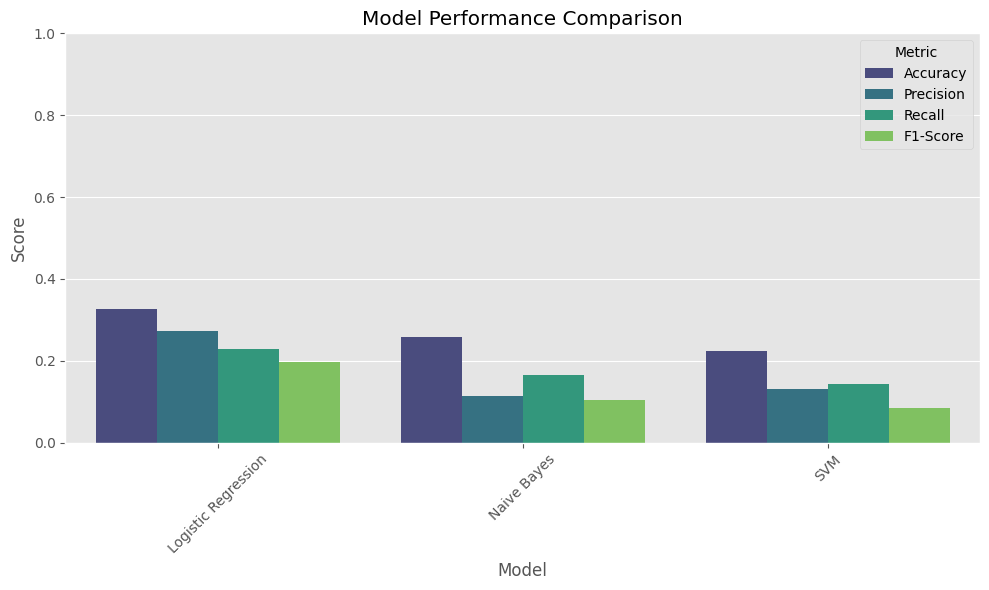

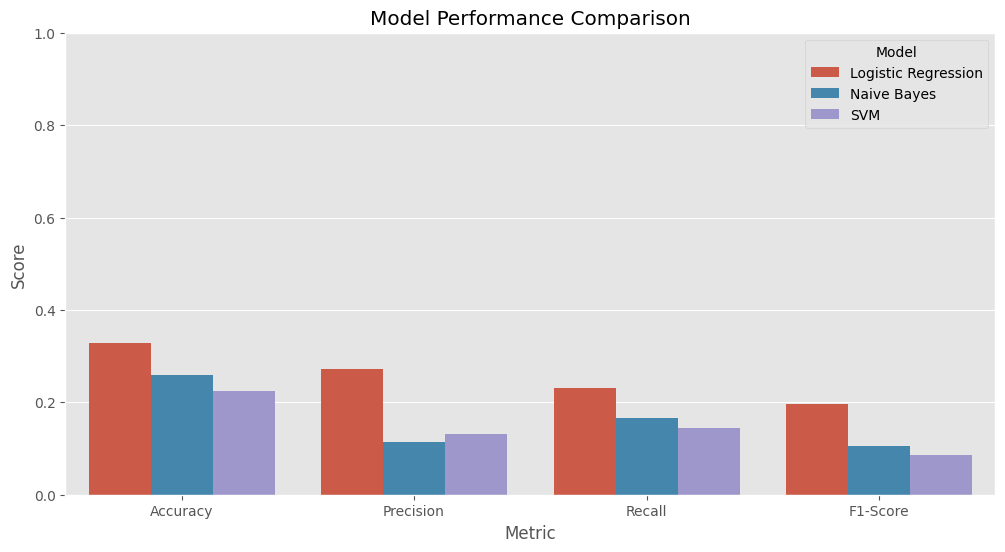

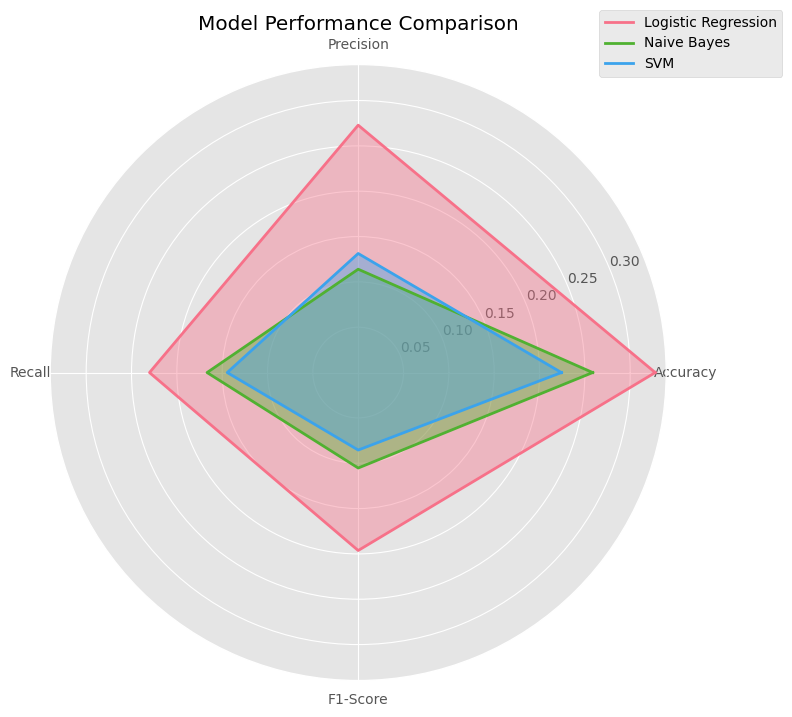

In [ ]:
def evaluate_and_plot(models, X_test, y_test):

    metrics = {
        'Model': [],
        'Metric': [],
        'Score': []
    }

    for model_name, model in models.items():
        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')

        # Append results
        metrics['Model'].extend([model_name] * 4)
        metrics['Metric'].extend(['Accuracy', 'Precision', 'Recall', 'F1-Score'])
        metrics['Score'].extend([accuracy, precision, recall, f1])

    # Create DataFrame for plotting
    metrics_df = pd.DataFrame(metrics)

    # Plot results
    plt.figure(figsize=(10, 6))
    sns.barplot(data=metrics_df, x='Model', y='Score', hue='Metric', palette='viridis')

    plt.title('Model Performance Comparison')
    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.legend(title='Metric')
    plt.ylim(0, 1)  # Assuming scores are in the range [0, 1]
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()



    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Metric', y='Score', hue='Model', data=metrics_df)
    plt.title('Model Performance Comparison')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend(title='Model')
    plt.show()



    # Prepare data for radar chart
    def prepare_radar_data(df):
        models = df['Model'].unique()
        metrics = df['Metric'].unique()
        radar_data = {}

        for model in models:
            model_data = df[df['Model'] == model]
            scores = [model_data[model_data['Metric'] == metric]['Score'].values[0] for metric in metrics]
            radar_data[model] = scores

        return radar_data, metrics

    radar_data, metrics = prepare_radar_data(metrics_df)
    num_vars = len(metrics)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # Make the plot circular
    angles += angles[:1]
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Plot each model
    colors = sns.color_palette('husl', len(radar_data))
    for (model, data), color in zip(radar_data.items(), colors):
        data += data[:1]  # Complete the loop
        ax.plot(angles, data, color=color, linewidth=2, linestyle='solid', label=model)
        ax.fill(angles, data, color=color, alpha=0.4)

    # Set labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)
    plt.title('Model Performance Comparison')
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    plt.show()




# Evaluate and plot
evaluate_and_plot(models, X_test_tfidf, y_test)

# State of the Art Models

This section delves into fine-tuning and pre-trained models using various state-of-the-art models. Both approaches are tested: fine-tuning a given model with a custom classification head and using the its pre-trained equivalent.

This dual approach allows us to compare the flexibility and performance of a customized fine-tuning process against the convenience and effectiveness of utilizing a pre-configured model specifically designed for sequence classification.


---

Fine-tuning a model, like RoBERTa, using RobertaModel involves loading the pre-trained RoBERTa model, adding a custom classification head (e.g., a fully connected layer), and then training this custom architecture on a specific task.

In contrast, using a pre-trained model, like RobertaForSequenceClassification, leverages an existing architecture specifically designed for sequence classification tasks. This model already includes a classification head optimized for the task, simplifying the process since you only need to fine-tune the model on your dataset without designing a custom head.

The key difference is that a model like RobertaModel with a custom head offers more customization and control, while a model like RobertaForSequenceClassification offers convenience and a ready-to-use architecture for classification tasks.


### Defining useful functions and classes

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

def tokenize_data(df, tokenizer, max_length=512):
    return tokenizer(df['cleaned_text'].tolist(), truncation=True, padding='max_length', max_length=max_length, return_tensors="pt")

def compute_metrics(eval_pred):
    logits, labels = eval_pred

    if isinstance(logits, torch.Tensor):
        logits = logits.cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.cpu().numpy()

    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

This function plots the metrics performance on the validation set along each epoch for a chosen model



In [ ]:
def plot_metrics(metrics):
    # Extract epochs
    metrics = metrics[:-2]
    epochs = range(1, len(metrics) + 1)

    # Initialize lists to store metrics
    accuracy = []
    f1 = []
    loss = []

    # Populate the lists with the metrics
    for metric in metrics:
        accuracy.append(metric.get('eval_accuracy', None))
        f1.append(metric.get('eval_f1', None))
        loss.append(metric.get('eval_loss', None))

    plt.figure(figsize=(15, 5))

    # Plot accuracy
    plt.subplot(1, 3, 1)
    plt.plot(epochs, accuracy, 'b-', label='Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    # Plot F1-score
    plt.subplot(1, 3, 2)
    plt.plot(epochs, f1, 'r-', label='F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('F1 Score over Epochs')
    plt.legend()

    # Plot loss
    plt.subplot(1, 3, 3)
    plt.plot(epochs, loss, 'g-', label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    # Save the plot to a file
    plt.tight_layout()
    plt.show()

This function plots the metrics performance on the test set after training for a chosen model has been completed

In [ ]:
def plot_test_results(test_results):
    # Define the metrics of interest
    performance_metrics = ['eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall']

    # Convert dictionary to DataFrame for easier plotting
    df = pd.DataFrame(list(test_results.items()), columns=['Metric', 'Value'])

    # Filter DataFrame to include only the performance metrics
    performance_df = df[df['Metric'].isin(performance_metrics)]

    plt.figure(figsize=(10, 6))

    # Plot barplot for performance metrics
    sns.barplot(x='Metric', y='Value', data=performance_df, palette='coolwarm')

    # Annotate each bar with the value
    for index, row in performance_df.iterrows():
        plt.text(row.name-1, row.Value + 0.01, f'{row.Value:.2f}', color='black', ha='center')

    plt.title('Test set Results')
    plt.ylabel('Value')
    plt.xlabel('Metric')
    plt.ylim(0, 1)  # Set y-axis limit for better visibility
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

This function plots the metrics performance on the test set of all models and compares them using suitable visualisation

In [ ]:
def prepare_data(model_results):
    # Initialize an empty dictionary to store the data
    data = {
        'Model': [],
        'Metric': [],
        'Value': []
    }

    # Define the list of model names and corresponding metrics
    model_names = ["roberta", "electra", "xlnet"]
    metrics = ['eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall']
    metric_names = ['Accuracy', 'F1 Score', 'Precision', 'Recall']

    for i, model_result in enumerate(model_results):
        model_name = model_names[i]
        for metric, metric_name in zip(metrics, metric_names):
            data['Model'].append(model_name)
            data['Metric'].append(metric_name)
            data['Value'].append(model_result[metric])

    return pd.DataFrame(data)


# Define the plotting function
def plot_model_comparison(df):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Metric', y='Value', hue='Model', data=df)
    plt.title('Model Comparison: Accuracy, F1 Score, Precision, and Recall')
    plt.ylim(0, 1)
    plt.ylabel('Score')
    plt.xlabel('Metric')
    plt.legend(title='Model')
    plt.show()

# Fine-tuning Roberta, Electra and XLNet

In [ ]:
def create_model_and_tokenizer(model_name, num_labels):
    if "roberta" in model_name:
        tokenizer = RobertaTokenizer.from_pretrained(model_name)
        model_class = CustomRobertaModel
    elif "xlnet" in model_name:
        tokenizer = XLNetTokenizer.from_pretrained(model_name)
        model_class = CustomXLNetModel
    elif "electra" in model_name:
        tokenizer = ElectraTokenizer.from_pretrained(model_name)
        model_class = CustomElectraModel
    else:
        raise ValueError("Unsupported model type")

    model = model_class(num_labels=num_labels)

    # Print the summary of the model
    input_ids = torch.zeros(4, 128, dtype=torch.long)  # Batch size 1, sequence length 128, dtype long
    attention_mask = torch.ones(4, 128, dtype=torch.long)  # Batch size 1, sequence length 128, dtype long

    summary(model, input_data=(input_ids, attention_mask))

    return model, tokenizer



class CustomRobertaModel(nn.Module):
    def __init__(self, num_labels=10):
        super(CustomRobertaModel, self).__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.dropout = nn.Dropout(p=0.3)  # Add a dropout layer with a 30% dropout rate
        self.classifier = nn.Linear(self.roberta.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(outputs.last_hidden_state[:, 0, :])  # Apply dropout to [CLS] token's hidden state
        logits = self.classifier(pooled_output)
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.classifier.out_features), labels.view(-1))
        return (loss, logits) if loss is not None else logits


class CustomXLNetModel(nn.Module):
    def __init__(self, num_labels=10):
        super(CustomXLNetModel, self).__init__()
        self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')
        self.dropout = nn.Dropout(p=0.3)  # Add a dropout layer with a 30% dropout rate
        self.classifier = nn.Linear(self.xlnet.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.xlnet(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(outputs.last_hidden_state[:, 0, :])  # Apply dropout to [CLS] token's hidden state
        logits = self.classifier(pooled_output)
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.classifier.out_features), labels.view(-1))
        return (loss, logits) if loss is not None else logits


class CustomElectraModel(nn.Module):
    def __init__(self, num_labels=10):
        super(CustomElectraModel, self).__init__()
        self.electra = ElectraModel.from_pretrained('google/electra-base-discriminator')
        self.dropout = nn.Dropout(p=0.3)  # Add a dropout layer with a 30% dropout rate
        self.classifier = nn.Linear(self.electra.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.electra(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(outputs.last_hidden_state[:, 0, :])  # Apply dropout to [CLS] token's hidden state
        logits = self.classifier(pooled_output)
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.classifier.out_features), labels.view(-1))
        return (loss, logits) if loss is not None else logits


# Custom callback to save metrics at the end of each epoch
class CustomCallback(TrainerCallback):
    def __init__(self, output_dir='./results', metrics_filename='metrics.json'):
        self.metrics = []
        self.output_dir = output_dir
        if "electra" in metrics_filename:
            self.metrics_filename = "fine_tuned_" + "electra_base_discriminator"
        else:
            self.metrics_filename = "fine_tuned_" + metrics_filename
        os.makedirs(self.output_dir, exist_ok=True)

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics and state.is_local_process_zero:
            if state.epoch is not None:  # This ensures we capture only at the end of an epoch
                self.metrics.append(metrics)
                # Save metrics to a JSON file
                with open(os.path.join(self.output_dir, self.metrics_filename), 'w') as f:
                    json.dump(self.metrics, f, indent=4)


def train_and_evaluate(model_name, train_df, val_df, test_df, num_labels, output_dir='./results', num_train_epochs=3):
    model, tokenizer = create_model_and_tokenizer(model_name, num_labels)


    train_encodings = tokenize_data(train_df, tokenizer)
    val_encodings = tokenize_data(val_df, tokenizer)
    test_encodings = tokenize_data(test_df, tokenizer)


    train_labels = train_df['class'].tolist()
    val_labels = val_df['class'].tolist()
    test_labels = test_df['class'].tolist()

    train_dataset = CustomDataset(train_encodings, train_labels)
    val_dataset = CustomDataset(val_encodings, val_labels)
    test_dataset = CustomDataset(test_encodings, test_labels)

    training_args = TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy='epoch',
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=num_train_epochs,
        weight_decay=0.01,
    )

    custom_callback = CustomCallback(output_dir=output_dir, metrics_filename=model_name)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[custom_callback]
    )


    torch.cuda.empty_cache()
    trainer.train()

    # Save the model weights
    trainer.save_model("./fine_tuned_model/" + model_name)

    eval_results = trainer.evaluate()

    test_results = trainer.evaluate(test_dataset)
    print(f"Test results: {test_results}")

    return custom_callback.metrics, test_results

### RoBERTa

RoBERTa is an optimized variant of BERT, designed by Facebook AI, that enhances performance by training on a larger dataset with longer training times and dynamic masking strategies.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,2.216750,0.189655,0.049351,0.148214,0.068984
2,No log,1.972182,0.379310,0.236111,0.273056,0.212082
3,No log,1.796359,0.482759,0.212740,0.340000,0.242807


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test results: {'eval_loss': 1.8192875385284424, 'eval_accuracy': 0.41379310344827586, 'eval_precision': 0.23677248677248677, 'eval_recall': 0.30952380952380953, 'eval_f1': 0.257052888631836, 'eval_runtime': 1.6342, 'eval_samples_per_second': 35.492, 'eval_steps_per_second': 2.448, 'epoch': 3.0}


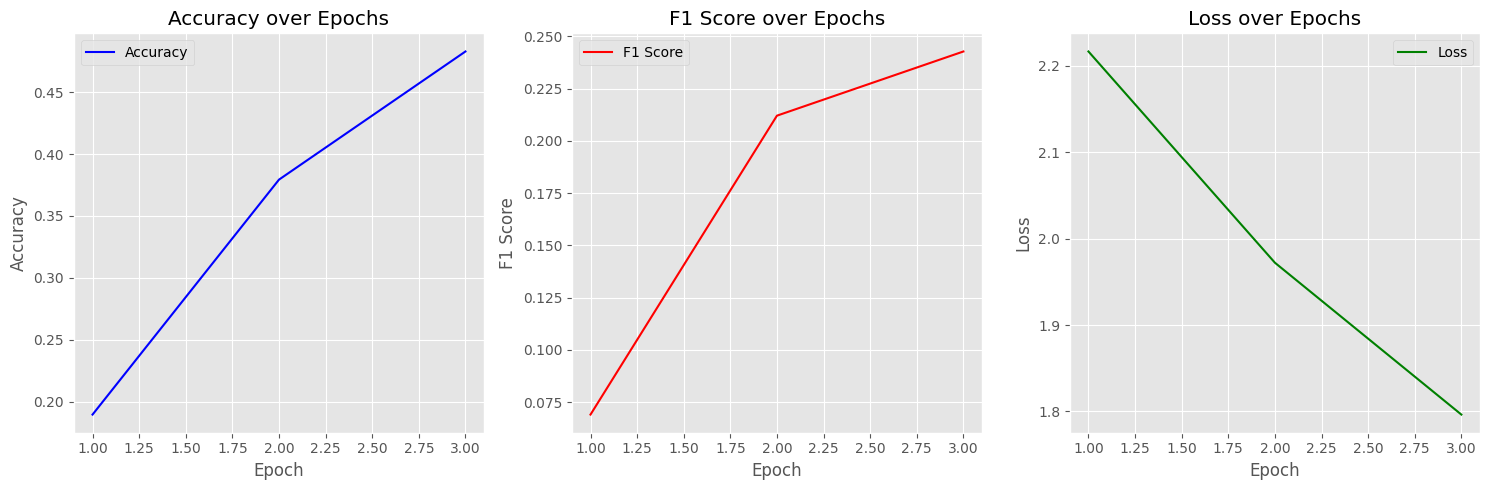

In [ ]:
roberta_metrics, roberta_test_results = train_and_evaluate('roberta-base', train_df, val_df, test_df, num_labels=10)

plot_metrics(roberta_metrics)

<ipython-input-22-79cf214111c4>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metric', y='Value', data=performance_df, palette='coolwarm')


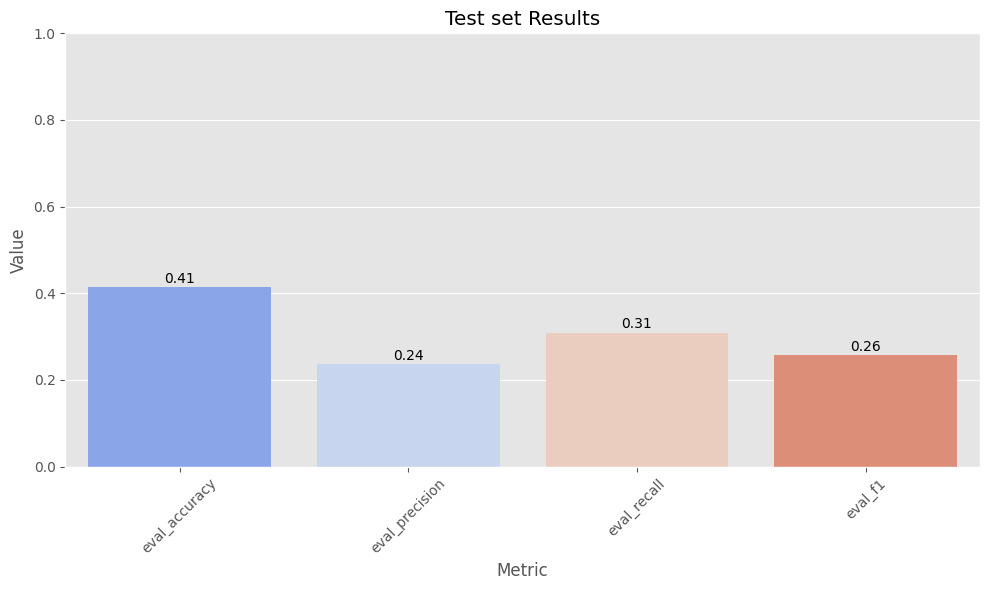

In [ ]:
plot_test_results(roberta_test_results)

### Electra

Electra is a language model developed by Google Research that improves efficiency by replacing words in input text with generated candidates and training the model to distinguish between real and fake words, leading to faster and more effective pre-training.

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,2.227377,0.155172,0.033075,0.116071,0.047677
2,No log,2.183993,0.155172,0.042297,0.125000,0.050805
3,No log,2.152523,0.155172,0.146296,0.122500,0.059314


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test results: {'eval_loss': 2.1127207279205322, 'eval_accuracy': 0.20689655172413793, 'eval_precision': 0.13095238095238096, 'eval_recall': 0.13333333333333333, 'eval_f1': 0.07070707070707072, 'eval_runtime': 1.8487, 'eval_samples_per_second': 31.374, 'eval_steps_per_second': 2.164, 'epoch': 3.0}


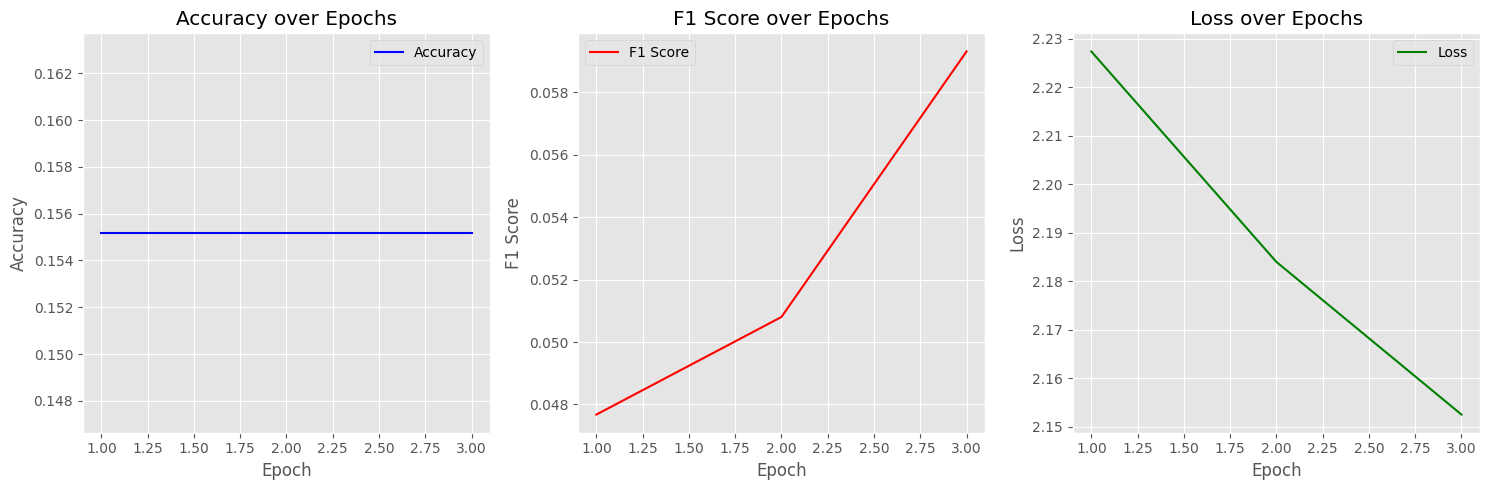

In [ ]:
electra_metrics, electra_test_results = train_and_evaluate('google/electra-base-discriminator', train_df, val_df, test_df, num_labels=10)

plot_metrics(electra_metrics)

<ipython-input-22-79cf214111c4>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metric', y='Value', data=performance_df, palette='coolwarm')


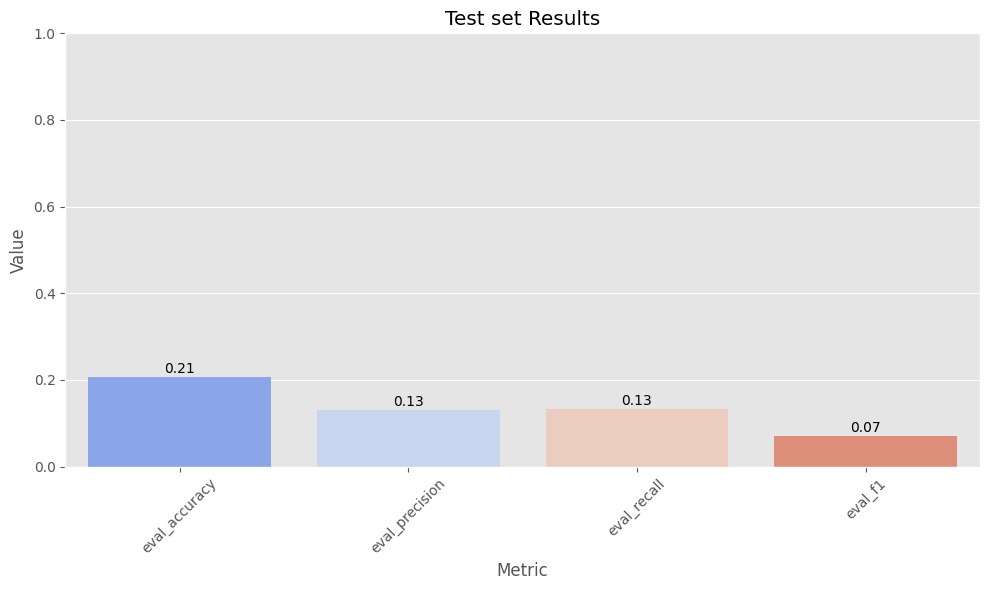

In [ ]:
plot_test_results(electra_test_results)

### XLNet

XLNet is a generalized autoregressive pre-training model by Google that combines the benefits of autoregressive and autoencoding models, capturing bidirectional context and handling longer dependencies through permutation-based training.

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,2.323739,0.120690,0.012500,0.087500,0.021875
2,No log,2.198100,0.224138,0.119192,0.160714,0.109494
3,No log,2.133634,0.258621,0.126053,0.175079,0.130621


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test results: {'eval_loss': 2.130164623260498, 'eval_accuracy': 0.25862068965517243, 'eval_precision': 0.1657848324514991, 'eval_recall': 0.1952380952380952, 'eval_f1': 0.15889724310776943, 'eval_runtime': 6.2703, 'eval_samples_per_second': 9.25, 'eval_steps_per_second': 0.638, 'epoch': 3.0}


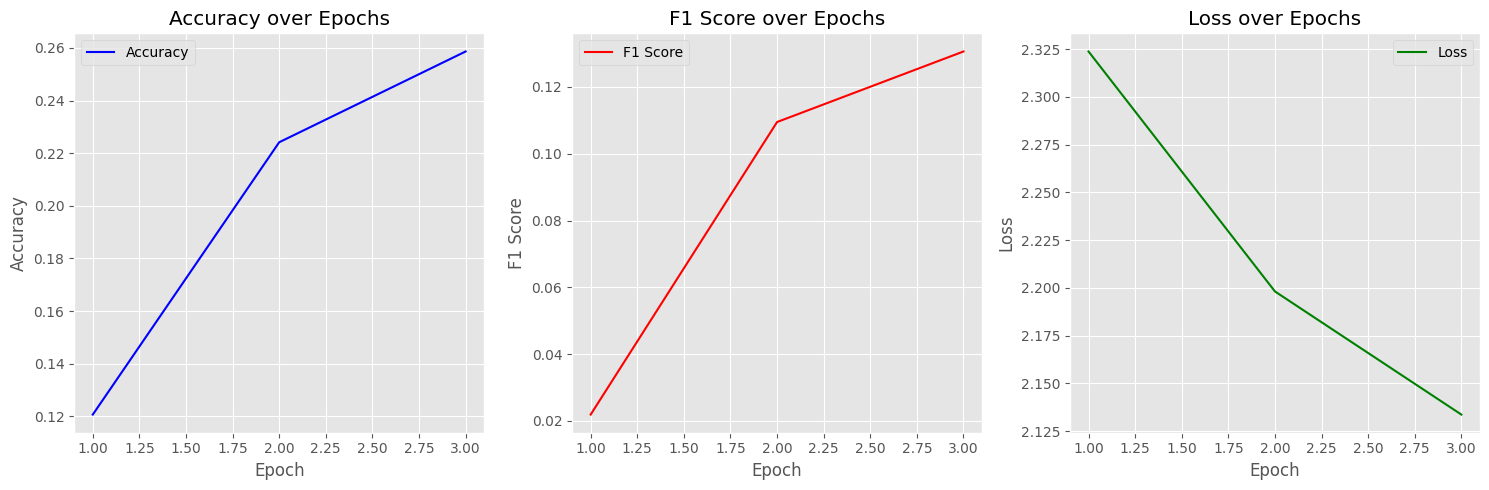

In [ ]:
xlnet_metrics, xlnet_test_results = train_and_evaluate('xlnet-base-cased', train_df, val_df, test_df, num_labels=10)

plot_metrics(xlnet_metrics)

<ipython-input-22-79cf214111c4>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metric', y='Value', data=performance_df, palette='coolwarm')


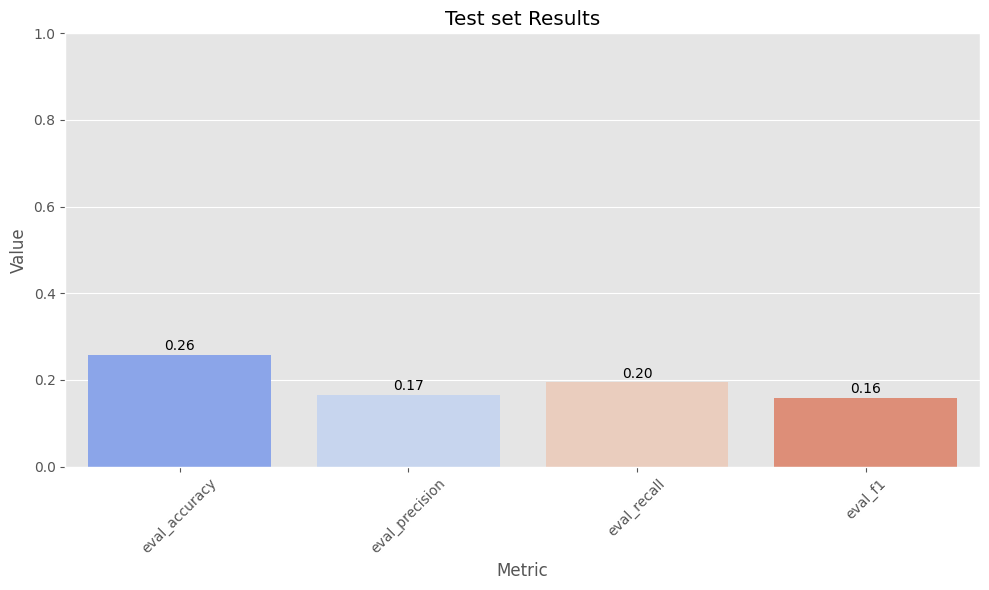

In [ ]:
plot_test_results(xlnet_test_results)

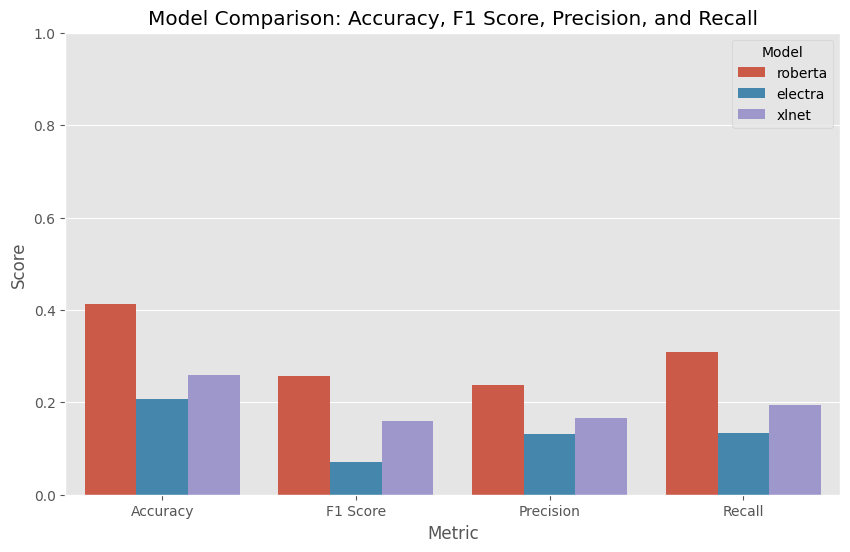

In [ ]:
# Prepare the data for model comparison
model_results = [roberta_test_results, electra_test_results, xlnet_test_results]
df = prepare_data(model_results)

# Plot the comparison
plot_model_comparison(df)

# Pre-trained Sequence Classification for Roberta, Electra and XLNet

In [ ]:
torch.cuda.empty_cache()

# Custom callback to save metrics at the end of each epoch
class CustomCallback(TrainerCallback):
    def __init__(self, output_dir='./results', metrics_filename='metrics.json'):
        self.metrics = []
        self.output_dir = output_dir
        if "electra" in metrics_filename:
            self.metrics_filename = "pre_trained_" + "electra_base_discriminator"
        else:
            self.metrics_filename = "pre_trained_" + metrics_filename
        os.makedirs(self.output_dir, exist_ok=True)

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics and state.is_local_process_zero:
            if state.epoch is not None:  # This ensures we capture only at the end of an epoch
                self.metrics.append(metrics)
                # Save metrics to a JSON file
                with open(os.path.join(self.output_dir, self.metrics_filename), 'w') as f:
                    json.dump(self.metrics, f, indent=4)



def evaluate_model(model_name, train_df, val_df, test_df, num_labels, output_dir='./results', num_train_epochs=3):
    # Select the appropriate model and tokenizer
    if "roberta" in model_name:
        tokenizer = RobertaTokenizer.from_pretrained(model_name)
        model_class = RobertaForSequenceClassification
    elif "xlnet" in model_name:
        tokenizer = XLNetTokenizer.from_pretrained(model_name)
        model_class = XLNetForSequenceClassification
    elif "electra" in model_name:
        tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator')
        model_class = ElectraForSequenceClassification
    else:
        raise ValueError("Unsupported model type")

    model = model_class.from_pretrained(model_name, num_labels=10)


    train_encodings = tokenize_data(train_df, tokenizer)
    val_encodings = tokenize_data(val_df, tokenizer)
    test_encodings = tokenize_data(test_df, tokenizer)

    train_labels = train_df['class'].tolist()
    val_labels = val_df['class'].tolist()
    test_labels = test_df['class'].tolist()

    train_dataset = CustomDataset(train_encodings, train_labels)
    val_dataset = CustomDataset(val_encodings, val_labels)
    test_dataset = CustomDataset(test_encodings, test_labels)

    training_args = TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy='epoch',
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=num_train_epochs,
        weight_decay=0.01,
    )

    custom_callback = CustomCallback(output_dir=output_dir, metrics_filename=model_name)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[custom_callback]
    )

    # Train the model
    trainer.train()

    # Save the model weights
    trainer.save_model("./pre_trained_model/" + model_name)

    eval_results = trainer.evaluate()
    print(f"Evaluation results: {eval_results}")

    test_results = trainer.evaluate(test_dataset)
    print(f"Test results: {test_results}")

    return custom_callback.metrics, test_results

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,2.159509,0.137931,0.014035,0.100000,0.024615
2,No log,1.888261,0.379310,0.190000,0.275556,0.196171
3,No log,1.703512,0.551724,0.258056,0.378889,0.294939


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation results: {'eval_loss': 1.7035117149353027, 'eval_accuracy': 0.5517241379310345, 'eval_precision': 0.2580555555555556, 'eval_recall': 0.3788888888888889, 'eval_f1': 0.2949390681003584, 'eval_runtime': 0.5, 'eval_samples_per_second': 115.998, 'eval_steps_per_second': 16.0, 'epoch': 3.0}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test results: {'eval_loss': 1.7390666007995605, 'eval_accuracy': 0.43103448275862066, 'eval_precision': 0.2694145758661888, 'eval_recall': 0.33015873015873015, 'eval_f1': 0.27630390338991107, 'eval_runtime': 0.4117, 'eval_samples_per_second': 140.872, 'eval_steps_per_second': 19.431, 'epoch': 3.0}


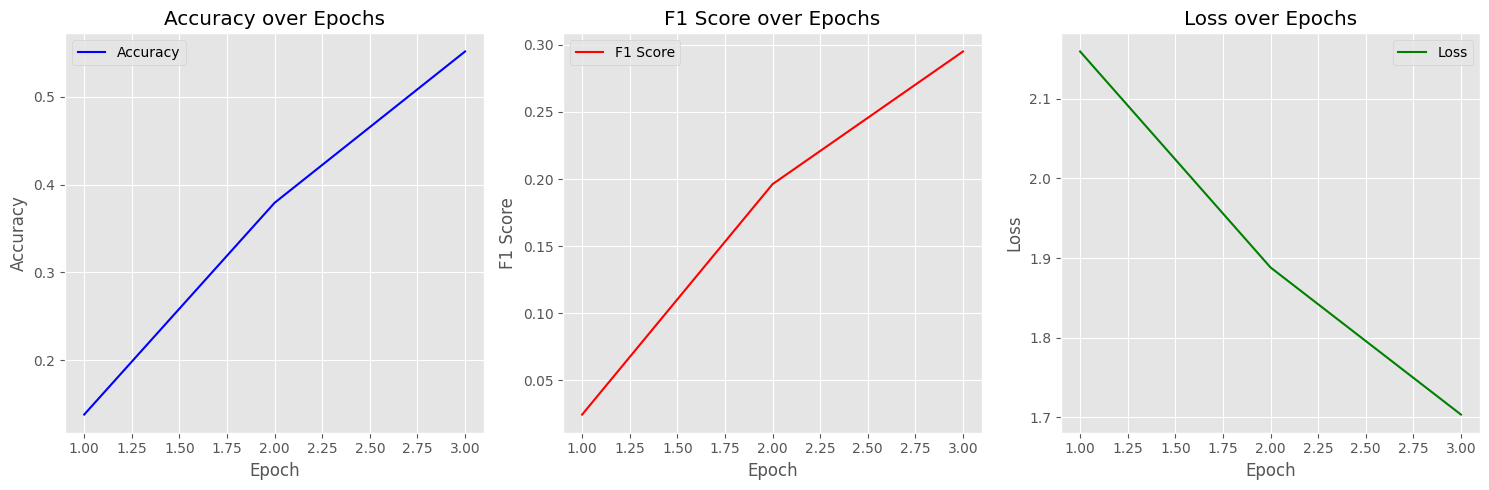

In [ ]:
roberta_metrics, roberta_test_results = evaluate_model('roberta-base', train_df, val_df, test_df, num_labels=10)

plot_metrics(roberta_metrics)

<ipython-input-19-79cf214111c4>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metric', y='Value', data=performance_df, palette='coolwarm')


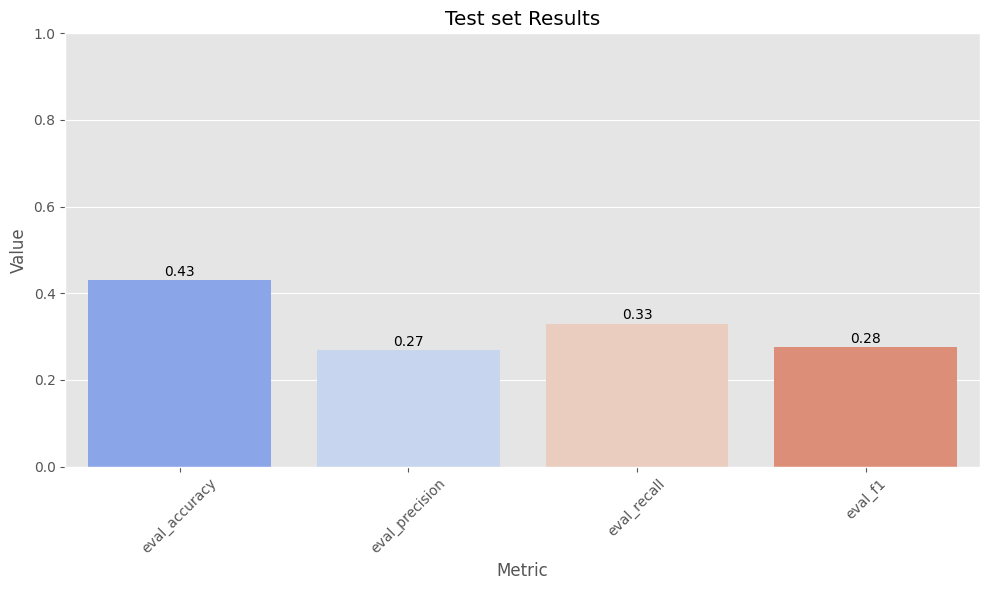

In [ ]:
plot_test_results(roberta_test_results)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,2.225684,0.206897,0.040669,0.157143,0.064127
2,No log,2.196406,0.224138,0.063636,0.173214,0.087166
3,No log,2.178221,0.258621,0.162059,0.196825,0.109532


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation results: {'eval_loss': 2.1782212257385254, 'eval_accuracy': 0.25862068965517243, 'eval_precision': 0.16205882352941176, 'eval_recall': 0.19682539682539685, 'eval_f1': 0.109531914893617, 'eval_runtime': 0.4666, 'eval_samples_per_second': 124.308, 'eval_steps_per_second': 17.146, 'epoch': 3.0}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test results: {'eval_loss': 2.168271064758301, 'eval_accuracy': 0.1896551724137931, 'eval_precision': 0.0607890499194847, 'eval_recall': 0.12222222222222223, 'eval_f1': 0.0743145743145743, 'eval_runtime': 0.4236, 'eval_samples_per_second': 136.91, 'eval_steps_per_second': 18.884, 'epoch': 3.0}


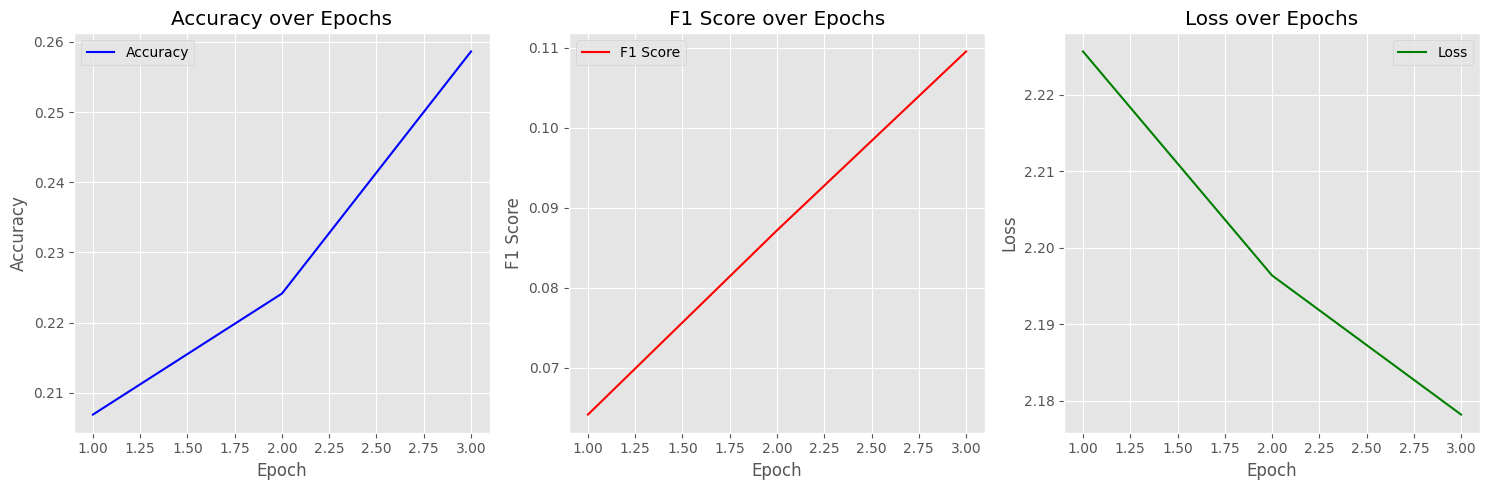

In [ ]:
electra_metrics, electra_test_results = evaluate_model('google/electra-base-discriminator', train_df, val_df, test_df, num_labels=10)

plot_metrics(electra_metrics)

<ipython-input-19-79cf214111c4>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metric', y='Value', data=performance_df, palette='coolwarm')


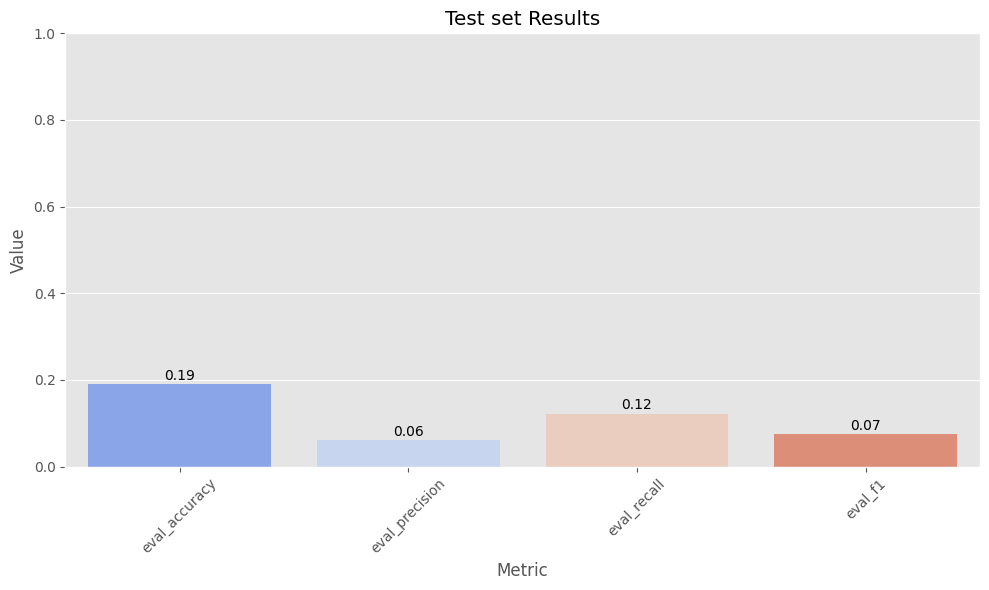

In [ ]:
plot_test_results(electra_test_results)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.899660,0.448276,0.335556,0.330159,0.283541
2,No log,1.557297,0.534483,0.317370,0.394603,0.330950
3,No log,1.439902,0.568966,0.430227,0.454603,0.409507


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation results: {'eval_loss': 1.43990159034729, 'eval_accuracy': 0.5689655172413793, 'eval_precision': 0.4302272727272728, 'eval_recall': 0.45460317460317456, 'eval_f1': 0.40950724637681163, 'eval_runtime': 0.5831, 'eval_samples_per_second': 99.474, 'eval_steps_per_second': 13.721, 'epoch': 3.0}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test results: {'eval_loss': 1.5005977153778076, 'eval_accuracy': 0.5172413793103449, 'eval_precision': 0.38058077188511974, 'eval_recall': 0.42116402116402113, 'eval_f1': 0.36425329903590775, 'eval_runtime': 0.592, 'eval_samples_per_second': 97.966, 'eval_steps_per_second': 13.513, 'epoch': 3.0}


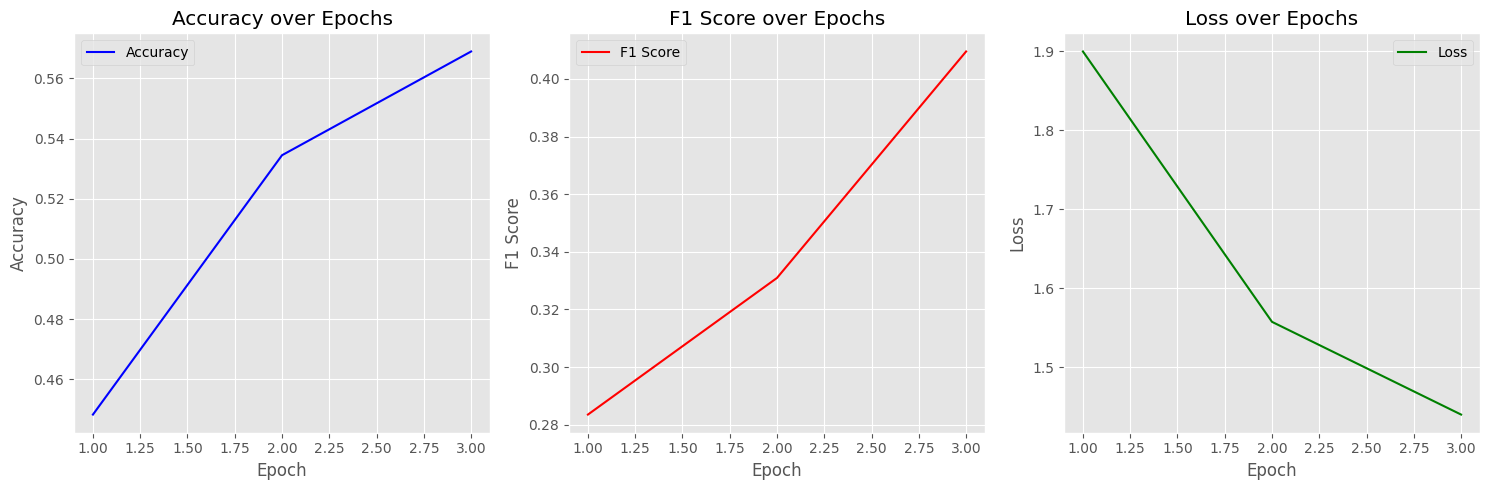

In [ ]:
xlnet_metrics, xlnet_test_results = evaluate_model('xlnet-base-cased', train_df, val_df, test_df, num_labels=10)

plot_metrics(xlnet_metrics)

<ipython-input-19-79cf214111c4>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metric', y='Value', data=performance_df, palette='coolwarm')


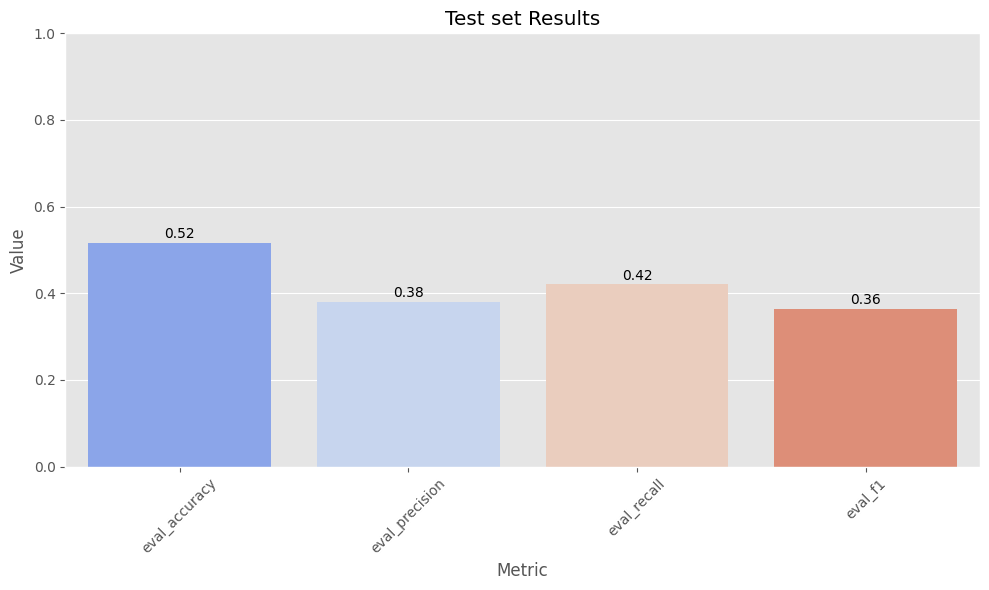

In [ ]:
plot_test_results(xlnet_test_results)

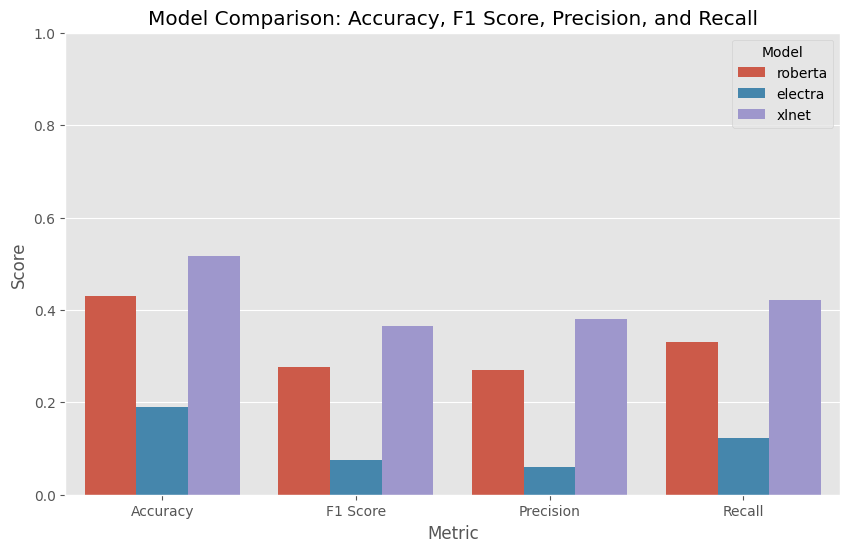

In [ ]:
# Prepare the data
model_results = [roberta_test_results, electra_test_results, xlnet_test_results]
df = prepare_data(model_results)

# Plot the comparison
plot_model_comparison(df)